# SafeNetAI

The dataset is from Kaggle's [Cyberbullying Classification Dataset](https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification)

## 1. Loading Libraries

* **NLTK** is a library for processing the message
* **WordCloud** and matplotlib are for visualization data
* **Pandas** is for loading csv file
* **RE** presents regular expression for finding words with specific patterns
* **Sklearn** is for generating train-test datasets randomly



In [2]:
# Data manipulation and analysis
import pandas as pd

# Natural Language Processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Regular expressions for text preprocessing
import re

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

# Visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Ensure plots are displayed inline
%matplotlib inline

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/degerahmet/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/degerahmet/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## 2. Loading data from the cyberbullying_tweets.csv file

In [3]:
df = pd.read_csv('cyberbullying_tweets.csv')

# Display the first few rows of the dataset to verify it's loaded correctly
df.head()

tweet_text cyberbullying_type
0  In other words #katandandre, your food was cra...  not_cyberbullying
1  Why is #aussietv so white? #MKR #theblock #ImA...  not_cyberbullying
2  @XochitlSuckkks a classy whore? Or more red ve...  not_cyberbullying
3  @Jason_Gio meh. :P  thanks for the heads up, b...  not_cyberbullying
4  @RudhoeEnglish This is an ISIS account pretend...  not_cyberbullying

## 3. Inspect the data

In [4]:
# Shape of the dataset (rows, columns)
df.shape

(47692, 2)

In [5]:
# Summary of the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [6]:
# Basic stats
df.describe()

tweet_text cyberbullying_type
count                                               47692              47692
unique                                              46017                  6
top     RT @sailorhg: the intro for my hardware hackin...           religion
freq                                                    2               7998

In [7]:
# List unique cyberbullying types
df['cyberbullying_type'].unique()

array(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying',
       'age', 'ethnicity'], dtype=object)

In [8]:
# Check for missing values
df.isnull().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

In [9]:
# Take a look at the first 20 tweets to get a sense of how we might need to clean the data
pd.set_option('display.max_colwidth', None)
df['tweet_text'].head(20)

0                                                                                  In other words #katandandre, your food was crapilicious! #mkr
1                            Why is #aussietv so white? #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc
2                                                                                   @XochitlSuckkks a classy whore? Or more red velvet cupcakes?
3                                        @Jason_Gio meh. :P  thanks for the heads up, but not too concerned about another angry dude on twitter.
4                                        @RudhoeEnglish This is an ISIS account pretending to be a Kurdish account.  Like Islam, it is all lies.
5            @Raja5aab @Quickieleaks Yes, the test of god is that good or bad or indifferent or weird or whatever, it all proves gods existence.
6                                                                                         Itu sekolah ya bukan tempat bully! Ga ja

In [10]:
# List the unique classification types
list(df['cyberbullying_type'].unique())

['not_cyberbullying',
 'gender',
 'religion',
 'other_cyberbullying',
 'age',
 'ethnicity']

## 4. Clean the tweets
Let's remove usernames, links, special characters, etc. We'll keep the column for the original tweet, and add columns for:

- **cleaned_tweet_text_with_hashtags**: Removes usernames, links, etc but preserves hashtags as those may have some semantic meaning
- **cleaned_tweet_text_without_hashtags**: Same as above but without hashtags, in case that proves more useful
- **hashtags_only**: Might be useful to see what hashtags are most associated with different types of bullying.

In [11]:
import re

# DISCLOSURE ON USE OF AI: We used ChatGPT for help on the regular expressions in this function
def clean_tweet(tweet, keep_hashtags=True):
    tweet = re.sub(r'@\w+', '', tweet)  # Remove @usernames
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)  # Remove URLs
    if not keep_hashtags:
        tweet = re.sub(r'#\w+', '', tweet)  # Remove hashtags if not keeping them
    tweet = re.sub(r'\d+', '', tweet)  # Remove numbers
    tweet = tweet.lower()  # Convert to lowercase
    # Keep hashtags in the text, remove other special characters
    tweet = re.sub(r'\W', ' ', tweet) if keep_hashtags else re.sub(r'[^a-zA-Z\s]', '', tweet)
    tweet = re.sub(r'\s+', ' ', tweet).strip()  # Remove extra spaces
    return tweet

def extract_hashtags(tweet):
    hashtags = re.findall(r'#\w+', tweet)
    return ' '.join(hashtags)

# Add cleaned columns with and without hastags
df['cleaned_tweet_text_with_hashtags'] = df['tweet_text'].apply(lambda x: clean_tweet(x, keep_hashtags=True))
df['cleaned_tweet_text_without_hashtags'] = df['tweet_text'].apply(lambda x: clean_tweet(x, keep_hashtags=False))

# Apply the extract_hashtags function to create a hashtags only column
df['hashtags_only'] = df['tweet_text'].apply(extract_hashtags)

# Display the cleaned tweets and the hashtags only to verify the changes
df[['cleaned_tweet_text_with_hashtags', 'cleaned_tweet_text_without_hashtags', 'hashtags_only']].head(20)


cleaned_tweet_text_with_hashtags  \
0                                                           in other words katandandre your food was crapilicious mkr   
1              why is aussietv so white mkr theblock imacelebrityau today sunrise studio neighbours wonderlandten etc   
2                                                                          a classy whore or more red velvet cupcakes   
3                             meh p thanks for the heads up but not too concerned about another angry dude on twitter   
4                                this is an isis account pretending to be a kurdish account like islam it is all lies   
5            yes the test of god is that good or bad or indifferent or weird or whatever it all proves gods existence   
6                                                               itu sekolah ya bukan tempat bully ga jauh kaya neraka   
7                                                         karma i hope it bites kat on the butt she is just nasty mkr   
8                                                                                     everything but mostly my priest   
9                                                                   rebecca black drops out of school due to bullying   
10                                                                                                                      
11                                                                                            the bully flushes on kd   
12                                                                                                         ughhhh mkr   
13                         rt turkish state has killed children in last years news googleçeviricitopluluğukürtçeyidee   
14  love that the best response to the hotcakes they managed to film was a non committal meh from some adolescent mkr   
15                                                              parem de fazer bullying comigo uhahuah bando de preto   
16                                                                           tadinhu de mim sofrendo bulling viu mimi   
17                                                           twitter is basically the angry letters of our generation   
18                    best pick up line hi you re cute i love how people call james potter is a bully mypatronusisyou   
19                                              now i gotta walk to classss i officially hate the stupid bus system _   

                                                                             cleaned_tweet_text_without_hashtags  \
0                                                                      in other words your food was crapilicious   
1                                                                                                why is so white   
2                                                                     a classy whore or more red velvet cupcakes   
3                        meh p thanks for the heads up but not too concerned about another angry dude on twitter   
4                           this is an isis account pretending to be a kurdish account like islam it is all lies   
5       yes the test of god is that good or bad or indifferent or weird or whatever it all proves gods existence   
6                                                          itu sekolah ya bukan tempat bully ga jauh kaya neraka   
7                                                        karma i hope it bites kat on the butt she is just nasty   
8                                                                                everything but mostly my priest   
9                                                              rebecca black drops out of school due to bullying   
10                                                                                                                 
11                                                                                       the bully flushes on kd   
12                                 

## 5. Visualizing the Data Using WordClouds

Next, we'll look at word clouds for each "Cyberbullying Type".

### Disclaimer / Trigger Warning

Please be advised that the following section contains visual representations of text data derived from instances of cyberbullying, which include offensive language and themes of harassment and abuse. Viewer discretion is advised, and some may find the content disturbing or triggering.

The purpose of this analysis is not to highlight negative aspects but to contribute to the development of tools and methodologies aimed at detecting and mitigating cyberbullying. Our goal is to foster safer online communities and support individuals who may be affected by these behaviors.

If you find any part of the following content unsettling, you may choose to skip this section. Resources and support are available for those who have been affected by cyberbullying.

---



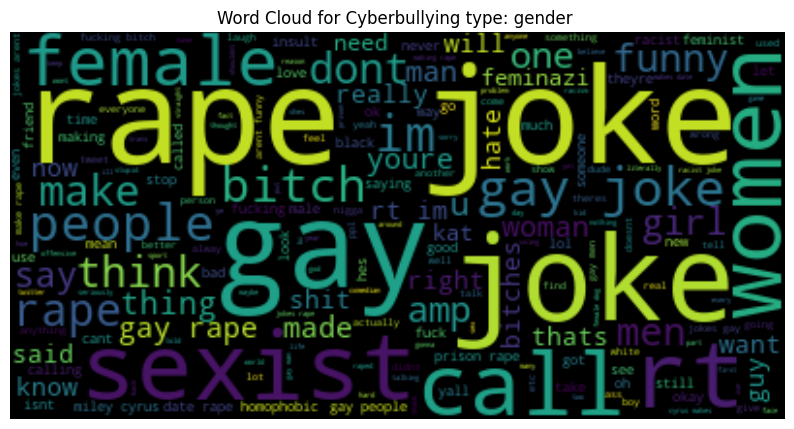

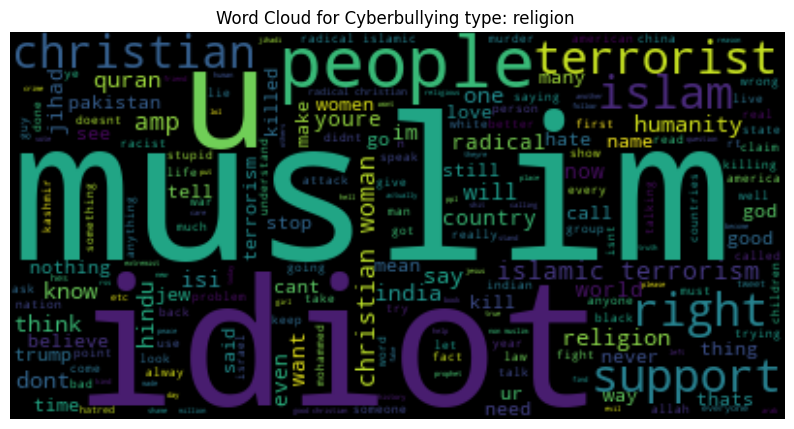

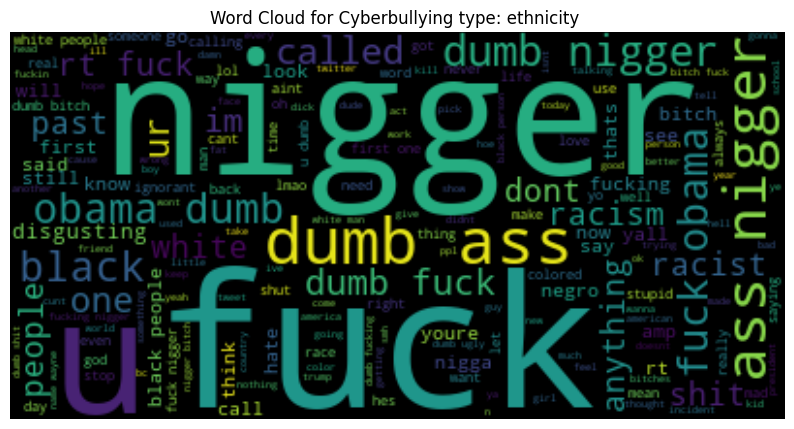

In [12]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Get unique cyberbullying types
cyberbullying_types = df['cyberbullying_type'].unique()

# Generate and display a word cloud for each type
for cb_type in cyberbullying_types:
    # Filter the dataset for the current type
    subset = df[df['cyberbullying_type'] == cb_type]
    text = " ".join(tweet for tweet in subset.cleaned_tweet_text_without_hashtags)

    # Generate wordcloud
    wordcloud = WordCloud().generate(text)

    # Display the wordcloud
    plt.figure(figsize = (10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for Cyberbullying type: {cb_type} ")
    plt.show()


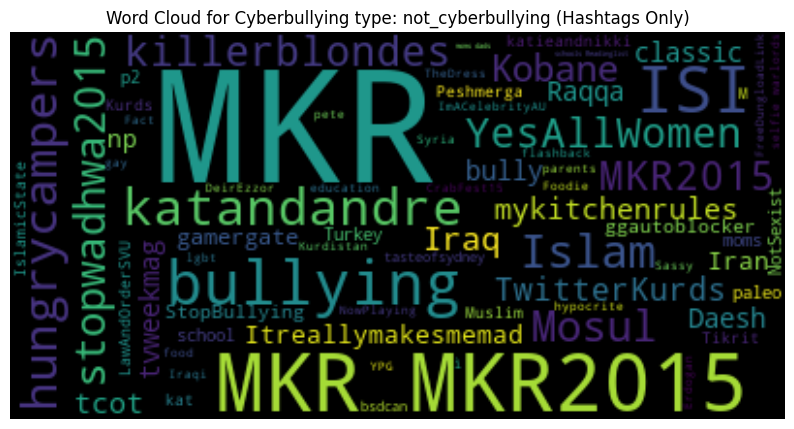

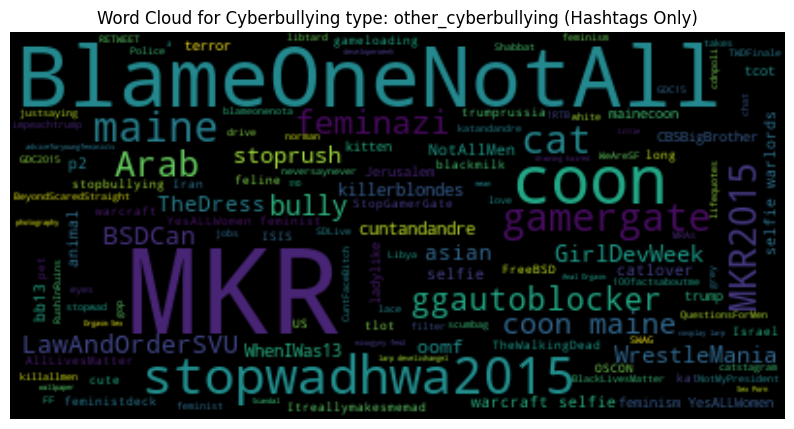

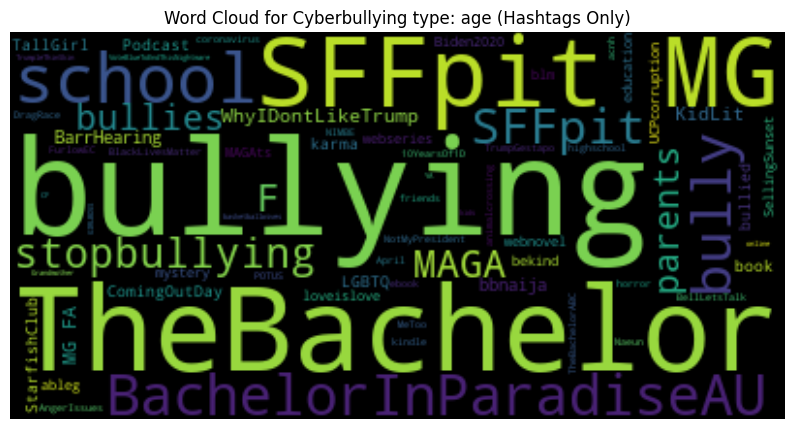

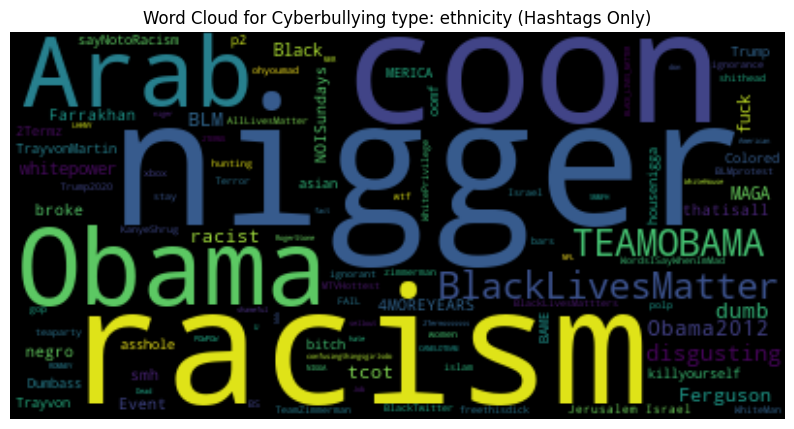

In [13]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Get unique cyberbullying types
cyberbullying_types = df['cyberbullying_type'].unique()

# Generate and display a word cloud for each type
for cb_type in cyberbullying_types:
    # Filter the dataset for the current type
    subset = df[df['cyberbullying_type'] == cb_type]
    text = " ".join(tweet for tweet in subset.hashtags_only)

    # Generate wordcloud
    wordcloud = WordCloud().generate(text)

    # Display the wordcloud
    plt.figure(figsize = (10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for Cyberbullying type: {cb_type} (Hashtags Only)")
    plt.show()


## 6. Sentiment Analysis
Let's add an additional column that assigns sentiment polarity using TextBlob. Here, a negative polarity indicates negative sentiment and positive polarity indicates positive sentiment (the range is from -1 to 1). This may be useful for later classification.

In [14]:
from textblob import TextBlob

def analyze_sentiment(tweet):
    analysis = TextBlob(tweet)
    # Return the polarity
    return analysis.sentiment.polarity

# Apply the sentiment analysis function to the cleaned tweets without hashtags
df['sentiment'] = df['cleaned_tweet_text_without_hashtags'].apply(analyze_sentiment)

# Display the DataFrame to verify the changes
df[['cleaned_tweet_text_without_hashtags', 'sentiment']].head(20)

cleaned_tweet_text_without_hashtags  \
0                                                                      in other words your food was crapilicious   
1                                                                                                why is so white   
2                                                                     a classy whore or more red velvet cupcakes   
3                        meh p thanks for the heads up but not too concerned about another angry dude on twitter   
4                           this is an isis account pretending to be a kurdish account like islam it is all lies   
5       yes the test of god is that good or bad or indifferent or weird or whatever it all proves gods existence   
6                                                          itu sekolah ya bukan tempat bully ga jauh kaya neraka   
7                                                        karma i hope it bites kat on the butt she is just nasty   
8                                                                                everything but mostly my priest   
9                                                              rebecca black drops out of school due to bullying   
10                                                                                                                 
11                                                                                       the bully flushes on kd   
12                                                                                                        ughhhh   
13                                                            rt turkish state has killed children in last years   
14  love that the best response to the hotcakes they managed to film was a noncommittal meh from some adolescent   
15                                                         parem de fazer bullying comigo uhahuah bando de preto   
16                                                                      tadinhu de mim sofrendo bulling viu mimi   
17                                                      twitter is basically the angry letters of our generation   
18                best pick up line hi youre cute i love how people call james potter is a bully mypatronusisyou   
19                                           now i gotta walk to classss i officially hate the stupid bus system   

    sentiment  
0   -0.125000  
1    0.000000  
2    0.200000  
3   -0.150000  
4    0.000000  
5   -0.050000  
6    0.000000  
7   -1.000000  
8    0.500000  
9   -0.145833  
10   0.000000  
11   0.000000  
12   0.000000  
13  -0.100000  
14   0.750000  
15   0.000000  
16   0.000000  
17  -0.500000  
18   0.666667  
19  -0.800000

In [15]:
# Calculate the average sentiment for each cyberbullying type and sort from worst to best
average_sentiment_by_type = df.groupby('cyberbullying_type')['sentiment'].mean().sort_values()

# Display the sorted average sentiment
average_sentiment_by_type


cyberbullying_type
ethnicity             -0.202576
religion              -0.083310
other_cyberbullying   -0.057656
not_cyberbullying      0.034808
age                    0.055548
gender                 0.073051
Name: sentiment, dtype: float64

Interestingly, age and gender bullying have sentiment polarities that appear to be more positive than "not_cyberbullying". Let's take a look at a few of these tweets.

In [16]:
# Filter for 'age' cyberbullying type and sort by sentiment in descending order
age_tweets_sorted = df[df['cyberbullying_type'] == 'age'].sort_values(by='sentiment', ascending=False)

# Display the top 5 tweets with the highest positive sentiment for 'age' bullying
age_tweets_sorted[['tweet_text', 'sentiment']].head(5)


tweet_text  \
34425  Nimbe was a very brilliant student, in fact he's one of the best students in his class. But then, his class mates bullies him. So, Nimbe had to deal with his family issues caused by his father at home and bullies at school.   
33532                                                                                                                                                                                                                  -The Best Ever-   
36546                                                                                                           Me: *stayed up all night thinking of the perfect thing to say to bully at school* Bully at school: hey weirdo Also me:   
35781                                                                                                                             It's almost as if these people were bullies at school and found the perfect job to continue doing so   
32751                                                                                                                                i want shawn as my brother, boyfriend, sugar daddy, best friend, cat sitter, bully, schools nerd.   

       sentiment  
34425        1.0  
33532        1.0  
36546        1.0  
35781        1.0  
32751        1.0

In [17]:
# Filter for 'gender' cyberbullying type and sort by sentiment in descending order
age_tweets_sorted = df[df['cyberbullying_type'] == 'gender'].sort_values(by='sentiment', ascending=False)

# Display the top 5 tweets with the highest positive sentiment for 'gender' bullying
age_tweets_sorted[['tweet_text', 'sentiment']].head(5)

tweet_text  \
8476                                                                                        ."@DustyPee: #cuntandandre Best thing I've heard! #mkr”   
8747                                              @mykitchenrules @bjtqld:  #mkr2015 #mkr I think Kat thinks she is the best chef ever. Ah hello no   
9197   RT @WendyMcElroy1: Cathy Young's @CathyYoung63 article on the Columbia U. rape accusation and mattress carrying is superb. Must read. http:…   
13435                                 RT @bjtqld: @mykitchenrules @bjtqld:  #mkr2015 #mkr I think Kat thinks she is the best chef ever. Ah hello no   
11999                                                                                  @LBigmann Best meme ever.  Yours?  Or where did you find it?   

       sentiment  
8476         1.0  
8747         1.0  
9197         1.0  
13435        1.0  
11999        1.0

In [18]:
# Comment on the above. Definitely seems like a limitation of this dataset that it lacks the context of surrounding tweets.
# For example, "@The_Loki_Jotunn Awesome." is the entirety of a tweet that's labeled as age bullying. Without context though, it's not very meaningful.

# 7. Data Preprocess for Naive Bayes





In this step we tried to facilitate the training of a Naive Bayes classifier for detecting instances of cyberbullying within a dataset of tweets. In the dataset, each tweet is associated with a type of cyberbullying, categorized under columns such as 'gender', 'religion', 'age', 'ethnicity', etc.


We determine in an if/else condition if the tweet contains any of the bullying types in types_of_bullying. If it contains then the condition returns 1 indicating it is cyberbullying, if not it returns 0 indicating it is not a cyberbullying tweet.





In [19]:
# Encoding
def condition(bullying_type):
    types_of_bullying = [
      'gender',
      'religion',
      'other_cyberbullying',
      'age',
      'ethnicity'
    ]
    if bullying_type not in types_of_bullying:
      return 0
    else:
      return 1

df['bully_status'] = df['cyberbullying_type'].apply(lambda bullying_type: condition(bullying_type))

To verify the effectiveness of our labeling function, we've isolated the tweets identified as instances of cyberbullying by applying a filter on the bully_status column. We have filtered conditions that bully_status are True (1) which means they are bully_tweets.

In [20]:
# Separate the dataset into bullying and not bullying
bully_df = df[df['bully_status'] == 1]
not_bully_df = df[df['bully_status'] == 0]

In [21]:
# Determine the number of samples needed for balance
n_samples = len(not_bully_df)

In [22]:
# Initialize an empty DataFrame to hold balanced bullying data
balanced_bully_df = pd.DataFrame()

In [23]:
# Count the number of types of bullying to distribute them evenly
n_types = len(bully_df['cyberbullying_type'].unique())

# Calculate samples per bullying type for even distribution
samples_per_type = n_samples // n_types

In [24]:
from sklearn.utils import resample

for bullying_type in bully_df['cyberbullying_type'].unique():
    type_df = bully_df[bully_df['cyberbullying_type'] == bullying_type]
    if len(type_df) > samples_per_type:
        # Undersample if this type has more examples than we need
        type_df_resampled = resample(type_df, replace=False, n_samples=samples_per_type, random_state=123)
    else:
        # Oversample if this type has fewer examples than we need
        type_df_resampled = resample(type_df, replace=True, n_samples=samples_per_type, random_state=123)
    balanced_bully_df = pd.concat([balanced_bully_df, type_df_resampled])

# Combine back with not bullying tweets and shuffle
balanced_df = pd.concat([balanced_bully_df, not_bully_df]).sample(frac=1).reset_index(drop=True)

In [25]:
# Now move on to feature extraction with the balanced dataset
# Feature Extraction for 'cleaned_tweet_text_with_hashtags' from the balanced dataset
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
tweetText = tfidf_vectorizer.fit_transform(balanced_df['cleaned_tweet_text_with_hashtags'])

In [26]:
# Prepare the status labels from the balanced dataset
status = balanced_df['bully_status'].astype(int)

# Splitting the data as train and testing for Naive Bayes classification
trainText, testText, trainStatus, testStatus = train_test_split(tweetText, status, test_size=0.20, random_state=42, stratify=status)

To check and see the status of train and test datasets.

In [27]:
trainStatus.head()

2448     1
12951    1
1399     0
3827     1
11781    0
Name: bully_status, dtype: int64

In [28]:
testStatus.head()

15641    1
3745     1
7194     1
9169     0
4856     1
Name: bully_status, dtype: int64

In [29]:
# Training the Model
classifier = MultinomialNB()
classifier.fit(trainText, trainStatus)

MultinomialNB()

In [30]:
# Evaluating the Model
testPrediction = classifier.predict(testText)
print("Accuracy:", accuracy_score(testStatus, testPrediction))
print("\nClassification Report:\n", classification_report(testStatus, testPrediction))

Accuracy: 0.7872876022655758

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.78      0.79      1589
           1       0.78      0.79      0.79      1589

    accuracy                           0.79      3178
   macro avg       0.79      0.79      0.79      3178
weighted avg       0.79      0.79      0.79      3178



In [31]:
predicted_tweets = tfidf_vectorizer.inverse_transform(testText)

In [32]:
def collapse_tweets(arr):
  tweets = []
  for x in arr:
    tweet = ''
    for y in x:
      tweet = tweet + ' ' + y
    tweets.append(tweet)
  return tweets

tweets = collapse_tweets(predicted_tweets)
df_predictions = pd.DataFrame({'tweets': tweets, 'predictions': testPrediction})

df_predictions.head(60)

tweets  \
0                                                                            fake report right happened remember time minutes   
1                                                                                abuse yes actually rape funny jokes gay just   
2                                                                    lt swear soon hair fuckin god got bitch dumb fuck nigger   
3                                                                                                           andre won kat mkr   
4                                                 born nation iran country look years muslims idiots muslim let friends islam   
5                                                                                  victim public shame violence support women   
6                                                                                                                  bye mkr rt   
7                                                                                  true haha wtf rape love jokes gay happened   
8                                                                                                                  old school   
9                                                                                                            fact room let ur   
10                                                                                                                       hate   
11                                                                                             sound andre look kat mkr doesn   
12                                                                                          win nikki katie hope need amp mkr   
13                                                                                wadhwa fine interesting guess talk way went   
14                                                                                                  season bring bloody ready   
15                                                                                                               xd hope okay   
16                                                                                              vs jihad line islamic rt time   
17                                                                                          great wait tell able doing things   
18                                                                                            fine line really bullying think   
19                                                                                                    laughing hard right omg   
20                                              situation glad hair getting want okay like girls bullied high ur school doing   
21                                                                              break kids bullies school child racism racist   
22                                                                                                           andre kat mkr rt   
23                                                                                                                 drasko mkr   
24                                                                                    start ain bullied girl high school know   
25                                                                                                        unfortunately thank   
26                                                                                                         morning idiots mkr   
27                                                                                         justice language big social amp rt   
28                                                                                                     bad don understand mkr   
29                                 away boys ain public single pretty really pic care don middle bullied girl high school ass   
30                                                                                 guess eat days ve sexist don girls rt

In [33]:
import json

# Replace 'your_notebook.ipynb' with the path to your notebook file
notebook_path = './SafeNetAI.ipynb'

with open(notebook_path, 'r') as notebook_file:
    notebook_json = json.load(notebook_file)

for cell in notebook_json['cells']:
    # Check if the cell is a markdown or code cell
    if cell['cell_type'] in ['markdown', 'code']:
        # Print the cell content
        # For markdown cells, it's directly available
        # For code cells, join the list into a single string
        cell_content = '\n'.join(cell['source'])
        print(cell_content)
        print('-' * 40)  # Just to separate content visually, you can remove this


# SafeNetAI



The dataset is from Kaggle's [Cyberbullying Classification Dataset](https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification)



## 1. Loading Libraries



* **NLTK** is a library for processing the message

* **WordCloud** and matplotlib are for visualization data

* **Pandas** is for loading csv file

* **RE** presents regular expression for finding words with specific patterns

* **Sklearn** is for generating train-test datasets randomly



----------------------------------------
# Data manipulation and analysis

import pandas as pd



# Natural Language Processing

import nltk

from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer



# Regular expressions for text preprocessing

import re



# Machine Learning

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import classification_report, accuracy_sc

In [34]:
# Step 1: Clean the text
# Assuming you have a function clean_text() similar to the one in your preprocessing step
cleaned_text = clean_tweet("@RudhoeEnglish This is an ISIS account pretending to be a Kurdish account. Like Islam, it is all lies.")

# Step 2 & 3: Additional preprocessing steps (lowercasing, removing stopwords, lemmatization) are included in your cleaning function

# Step 4: Vectorize the cleaned text
# Note: Ensure tfidf_vectorizer is the same instance used during training or has the same vocab
vectorized_text = tfidf_vectorizer.transform([cleaned_text])

# Step 5: Predict with the trained model
prediction = classifier.predict(vectorized_text)

# Step 6: Interpret the prediction
print("Predicted category:", prediction[0])


Predicted category: 0


In [35]:
not_bullying_texts = df[df['bully_status'] == 0]
not_bullying_texts['tweet_text'].sample(10)

6673                                                                                                                     @DemetriaFaith_ you okay?
842                                                                                             @harmlesstree2 Here again. https://t.co/xWJzpSodGj
145                                                                                                                               Annie &amp; Loyd
2389                                                                                                              @Sanaa_Amir made my Monday larki
4339       Suddenly 3 x the number of people who could ever possibly fill the tents pictured in the camp site earlier, rock up for breakfast. #MKR
3987    @Bruciebabe @ericcartmanfat @andyblueskyz @chezkig1 @End_Bigotry @edulixavot34 @georgegalloway @MaxBlumenthal This. http://t.co/NUrVhiKBHZ
4998                         She seems to be getting the most tweets, but @femfreq and @TheQuinnspiracy have seen much

In [36]:
not_bullying_texts = df[df['bully_status'] == 1]
not_bullying_texts['tweet_text'].sample(10)

32252                                  remember that one time i ended world hunger? and that one time i fought the school bully who was punching the nerd? and that one time i won the lottery and donated all of the money to end world poverty?
45858                                                                                                                                                                            @Nigger_Bear lol. People are dumb as fuck! Lol. But yea text me.
25384                                                                                                                                                              It might be time for a new profile pic for randi_ebooks http://t.co/SoJJ0B05OR
44222                                                                                                    @TEAMNOLO @nicolescherzy @iamdiddy FOR WHAT SHIT FOR WAYNES FUCKING ATTITTUDE FUCK EVERYTHING MAKE BABY'S YOU DUMB FUCKING MONKEY NIGGER
46877                           

In [37]:
df.head(50)

tweet_text  \
0                                                                                  In other words #katandandre, your food was crapilicious! #mkr   
1                            Why is #aussietv so white? #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc   
2                                                                                   @XochitlSuckkks a classy whore? Or more red velvet cupcakes?   
3                                        @Jason_Gio meh. :P  thanks for the heads up, but not too concerned about another angry dude on twitter.   
4                                        @RudhoeEnglish This is an ISIS account pretending to be a Kurdish account.  Like Islam, it is all lies.   
5            @Raja5aab @Quickieleaks Yes, the test of god is that good or bad or indifferent or weird or whatever, it all proves gods existence.   
6                                                                                         Itu sekolah ya bukan tempat bully! Ga jauh kaya neraka   
7                                                                                Karma. I hope it bites Kat on the butt. She is just nasty. #mkr   
8                                                                                                   @stockputout everything but mostly my priest   
9                                                                                             Rebecca Black Drops Out of School Due to Bullying:   
10                                                                                                          @Jord_Is_Dead http://t.co/UsQInYW5Gn   
11                                                                                              The Bully flushes on KD http://twitvid.com/A2TNP   
12                                                                                                                                   Ughhhh #MKR   
13    RT @Kurdsnews: Turkish state has killed 241 children in last 11 years http://t.co/JlvkE1epws  #news  ##GoogleÇeviriciTopluluğuKürtçeyideE…   
14                         Love that the best response to the hotcakes they managed to film was a non-committal "meh" from some adolescent. #MKR   
15                                                               @yasmimcaci @Bferrarii PAREM DE FAZER BULLYING COMIGO =( UHAHUAH BANDO DE PRETO   
16                                                                       @sarinhacoral @Victor_Maggi tadinhu de mim , sofrendo bulling viu MIMI'   
17                                                        @0xabad1dea @kelseytheodore2 twitter is basically the angry letters of our generation.   
18      Best pick up line? Hi, you're cute... ?: I love how people call James Potter is a bully. - mypatronusisyou: http://tumblr.com/xol3xl14zy   
19                                                                    Now I gotta walk to classss?! I officially hate the stupid bus system! -_-   
20     @halalcunty @biebervalue @liamxkiwi @greenlinerzjm @halalflaws I know Saudis chased girls into a burning building. http://t.co/8b1AclczN9   
21                                                                  Kids Love😘❤ @ Mohamad Bin Zayed City مدينة محمد بن زايد http://t.co/0xrOZSNn   
22              I still have Jack, Amsterdam, Ciroc, Crown, Bud Light, Lime-a-rita, and CRU in my love handles. I feel the jiggle when I walk...   
23            @scottyswaggod men are the ones that are going to push the real change. they are the ones in power, generally. we need their help.   
24                                                            Wishing my arena partner was on. &gt;.&gt;  Really want to get some PvP happening.   
25                                                                                   Education Nation: Bullying | Turn to 10 http://t.co/sxTIWtp   
26                                                                                                   @sand_dejesus Isso é bullying! @O_Pat

In [38]:
# Filter the DataFrame for "not_cyberbullying"
not_cyberbullying_tweets = df[df['cyberbullying_type'] == 'not_cyberbullying']

# Iterate through the first 50 "not_cyberbullying" tweets
for index, row in not_cyberbullying_tweets.head(50).iterrows():
    # Step 1: Clean the tweet
    cleaned_text = clean_tweet(row['tweet_text'])

    # Step 4: Vectorize the cleaned text
    vectorized_text = tfidf_vectorizer.transform([cleaned_text])

    # Step 5: Predict with the trained model
    prediction = classifier.predict(vectorized_text)

    # Step 6: Interpret and print the prediction
    predicted_category = "Bullying" if prediction[0] == 1 else "Not Bullying"
    print(f"Tweet: {row['tweet_text']}\nPrediction: {predicted_category}\n")


Tweet: In other words #katandandre, your food was crapilicious! #mkr
Prediction: Not Bullying

Tweet: Why is #aussietv so white? #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc
Prediction: Not Bullying

Tweet: @XochitlSuckkks a classy whore? Or more red velvet cupcakes?
Prediction: Not Bullying

Tweet: @Jason_Gio meh. :P  thanks for the heads up, but not too concerned about another angry dude on twitter.
Prediction: Not Bullying

Tweet: @RudhoeEnglish This is an ISIS account pretending to be a Kurdish account.  Like Islam, it is all lies.
Prediction: Not Bullying

Tweet: @Raja5aab @Quickieleaks Yes, the test of god is that good or bad or indifferent or weird or whatever, it all proves gods existence.
Prediction: Not Bullying

Tweet: Itu sekolah ya bukan tempat bully! Ga jauh kaya neraka
Prediction: Not Bullying

Tweet: Karma. I hope it bites Kat on the butt. She is just nasty. #mkr
Prediction: Not Bullying

Tweet: @stockputout everything but mos

Exporting the NB Model and TfidfVectorizer

In [39]:
import pickle

file = 'NB_Model.sav'
pickle.dump(classifier, open(file, 'wb'))

# Export the TfidfVectorizer
vectorizer_file = 'vectorizer.sav'
pickle.dump(tfidf_vectorizer, open(vectorizer_file, 'wb'))

In [ ]:
# Export the df
df.to_csv('cleaned_tweets.csv', index=False)